# Imports

In [1]:
!pip show ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Name: ipywidgets
Version: 7.7.1
Summary: IPython HTML widgets for Jupyter
Home-page: http://ipython.org
Author: IPython Development Team
Author-email: ipython-dev@scipy.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: ipykernel, ipython, ipython-genutils, jupyterlab-widgets, traitlets, widgetsnbextension
Required-by: bigframes, bqplot, cufflinks, ipyevents, ipyfilechooser, ipyleaflet, ipytree
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [14]:
import tensorflow as tf
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras

# Data

## Initializing Environment in Kaggle

In [3]:
dataset_dir = '/kaggle/working'

In [4]:
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

ModuleNotFoundError: No module named 'kaggle_secrets'

In [ ]:
# meta = dict(
#     id="ishansrivastava1308/Cloud-Images-19510",
#     title="Cloud images Dataset",
#     isPrivate=True,
#     licenses=[dict(name="other")]
# )

# with open(os.path.join('dataset-metadata.json'), 'w') as f:
#     json.dump(meta, f)


In [ ]:
# !kaggle datasets init

In [ ]:
# !kaggle datasets create -p {dataset_dir} --dir-mode zip

## Initializing Environment in Google Colab

In [15]:
import os
import json

from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = userdata.get("KAGGLE_KEY")

## Downloading Data in google colab

In [19]:
!kaggle datasets download ishansrivastava1308/cloud-images-19510 -p /content/kaggle/input --force
!unzip /content/kaggle/input/cloud-images-19510.zip -d /content/kaggle/input/cloud-images-19510 && rm /content/kaggle/input/cloud-images-19510.zip


Streaming output truncated to the last 5000 lines.
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913084000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913085000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913090000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913091000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913092000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913093000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913094000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913095000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913100000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913101000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913102000.jpg  
  inflating: /content/kaggle/input/cloud-images-19510/0913/0913103000.jpg  
  inflating: /content/kaggle/input/cl

In [17]:
rm -r kaggle/input/

## Undistorting Images

In [8]:
pwd = os.getcwd()

In [10]:
img = tf.keras.utils.load_img(os.path.join(pwd,'/kaggle/input/cloud-images-19510/0101/0101075000.jpg'), target_size = (800,800))
img

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/cloud-images-19510/0101/0101075000.jpg'

In [ ]:
dist = 0.4; f = 400;
dim = 2048
DIM=(dim, dim)
K=np.array([
    [f, 0.0, 1536/2],
    [0.0, f, 1536/2],
    [0.0, 0.0, 1.0]])
D=np.array([[dist],[dist],[dist],[dist]])


def undistort(img_path = None,zoom_out_factor = 1, balance=0.0, dim2=None, dim3=None,*args, **kwargs):
    img = cv2.imread(img_path)

    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K.copy()
#     scaled_K[0][0] /= zoom_out_factor
#     scaled_K[1][1] /= zoom_out_factor
#     scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
#     new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, , balance=balance)
    new_K = K.copy()
    new_K[0][0] /= zoom_out_factor
    new_K[1][1] /= zoom_out_factor
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    return undistorted_img






In [ ]:
def undistorted_wrap(dist = 0.4, f = 400 ,zoom_out_factor = 1, balance=0.0, dim2=None, dim3=None,*args, **kwargs):
    dist = 0.4; f = 400;
    dim = 2048
    DIM=(dim, dim)
    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])

    img = cv2.imread(img_path)

    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))

    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(undistorted_img)


In [ ]:
def undistorted_widget(**kwargs):
    image = undistort(**kwargs)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(image,)


In [ ]:
image_path = '/kaggle/input/cloud-images-19510/0105/0105112000.jpg'
img = cv2.imread(image_path)

def undistorted_wrap(img,dist = 0.4, f = 400 ,zoom_out_factor = 1, balance=0.0, dim2=None, dim3=None,*args, **kwargs):
    dist = 0.4; f = 400;
    dim = 2048
    DIM=(dim, dim)
    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])


    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))

    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(undistorted_img)


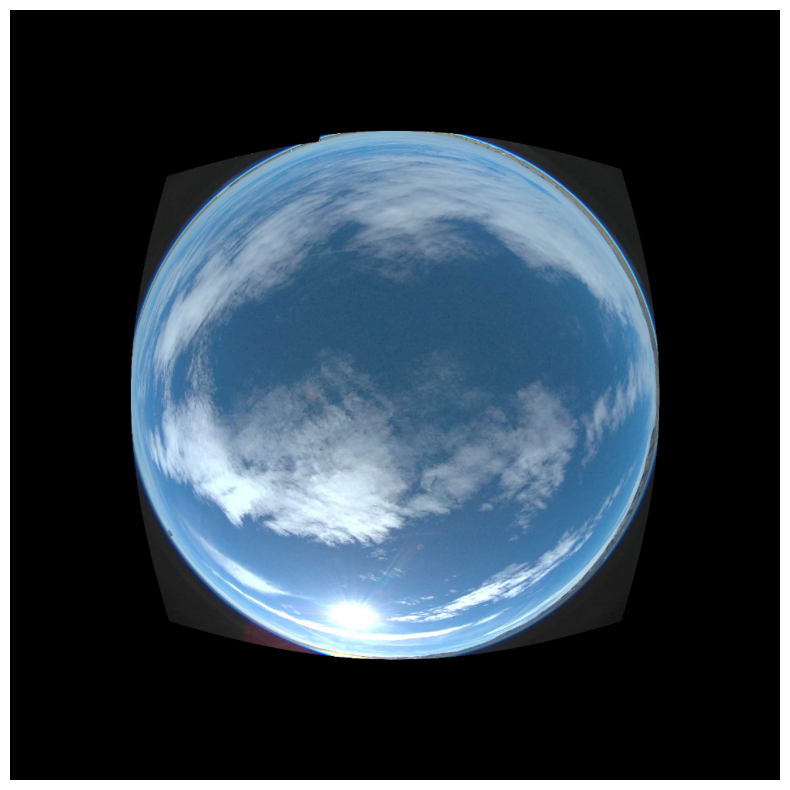

In [ ]:
undistorted_wrap(img,dist = 0.025,f = 600,zoom_out_factor = 1,balance = 1)

In [ ]:
undistorted_widget_wrap(img_path = '/kaggle/input/cloud-images-19510/0105/0105112000.jpg')(dist = 0.025,f = 600,zoom_out_factor = 1,balance = 1)

[ WARN:0@2369.151] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
%matplotlib inline

In [ ]:
import IPython
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed, FloatSlider, IntRangeSlider
balance = FloatSlider(min=0, max=1, value=1, description='Balance:')
display(interact(
    undistorted_widget_wrap,
    img = fixed('/kaggle/input/cloud-images-19510/0105/0105120000.jpg'),
    dist = FloatSlider(min = 0, max = 1, step = 0.00001, value = 0.01),
    f = IntSlider(min = 1, max = 1000, step = 1, value = 400),
    zoom_out_factor=FloatSlider(min=0, max=20, step=0.01, value=5),
    balance = balance,

))

#

interactive(children=(FloatSlider(value=0.01, description='dist', max=1.0, step=1e-05), IntSlider(value=400, d…

<function __main__.undistorted_widget_wrap(**kwargs)>

In [ ]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [ ]:
%matplotlib notebook
import ipywidgets as widgets

# For explicitly displaying widgets
from IPython.display import display

# Just need these for the demo purposes here
from datetime import datetime
import matplotlib.pyplot as plt
demo_IntSlider_1 = widgets.IntSlider(
    min=1,                      # The minimum value
    max=100,                    # The maximum value
    description='Int Slider 1', # Label
    value=53,                   # Default value
)

# Display the widget
display(demo_IntSlider_1)

In [ ]:
u_img = undistort('/kaggle/input/cloud-images-19510/0105/0105112000.jpg',zoom_out_factor = 100,balance = 1)
tf.keras.utils.array_to_img(u_img)

In [ ]:

fig,ax = plt.subplots(nrows = 3, ncols = 3)
axes = ax.flatten()
for a in axes:
    a.imshow()

In [ ]:
tf.keras.utils.array_to_img(map1)

In [ ]:
tf.keras.utils.array_to_img(undistort('/kaggle/input/cloud-images-19510/0101/0101075000.jpg',balance = 1), )

In [ ]:
plt.imshow(img)

In [ ]:
img

# Data Preprocessing

## Creating Tensorflow Datsets

In [ ]:
base_path = '/kaggle/input/cloud-images-19510'

In [ ]:
image_paths = [sorted([os.path.join(root,file) for file in files if file.endswith('.jpg')]) for root,dirs,files in os.walk(base_path) if len(dirs) == 0]

In [ ]:
flattened_image_paths = sorted([os.path.join(root,file) for root,dirs,files in os.walk(base_path) for file in files if not file.endswith('.csv')])

In [ ]:
def undistort_from_array(img, dim2 = None, dim3 = None, balance = 0):
    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K * dim1[0] / DIM[0]  # The values of K is to scale with image dimension.
    scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    return undistorted_img


In [ ]:
import tensorflow as tf

class Preprocessor:
    def __init__(
            self,
            filepaths : list[str]
    ):
        self.filepaths = filepaths
        self.dataset = None

    def get_dataset_iterator(self,func):
        if self.dataset:
            return self.dataset
        self.dataset = tf.data.Dataset.from_tensor_slices(self.filepaths)
        self.dataset = self.dataset.map(func, num_parallel_calls=tf.data.AUTOTUNE)
        # self.dataset = self.dataset.cache()
        # self.dataset = self.dataset.shuffle(buffer_size=1000)
        # self.dataset = self.dataset.batch(32)
        # self.dataset = self.dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return self.dataset
@tf.function
def load_preprocess_y(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

@tf.function
def get_image_from_path(file_path):
    return image

@tf.py_function(Tout=tf.float64)
def get_undistorted_img(file_path):
    path_str = file_path.numpy().decode('utf-8')
    image = undistort(path_str,zoom_out_factor = 10,balance = 1)
    return tf.convert_to_tensor(image,dtype = tf.float64)

In [ ]:
train_ds_x = Preprocessor(flattened_image_paths).get_dataset_iterator(get_undistorted_img)
# train_ds_x.map(get_undistorted_img)

In [ ]:
image_iter = train_ds_x.as_numpy_iterator()

In [ ]:
def show_grid_samples(ncols = 3,nrows = 3,scale = 1,**kwargs):
    figsize = (ncols * scale, nrows * scale)
    plt.tight_layout()
    fig,ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = figsize)
    axes = ax.flatten()
    for a in axes:
        a.imshow(image_iter.next()/255, interpolation = 'nearest')
        a.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()

In [ ]:
%matplotlib notebook

In [ ]:
show_grid_samples(ncols = 3,nrows = 10,scale = 5)